# MLP

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
file = r'/content/drive/MyDrive/Colab/mlp-mcr/dataset.csv'

Data

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv(file)

# dataset
dataset = df.values
X = dataset[:, 6] # mt column
print(np.min(X)," ",np.max(X))
print(len(X))
Y = dataset[:, 5] # mcr column
print(np.min(Y)," ",np.max(Y))
print(len(Y))

0.01   5858.833333333333
179996
0.0253444780071999   4874.2
179996


Correlation

In [4]:
from scipy.stats import pearsonr

corr, _ = pearsonr(X, Y)
print('Pearsons correlation: %.3f' % corr)

Pearsons correlation: 0.752


Scatter

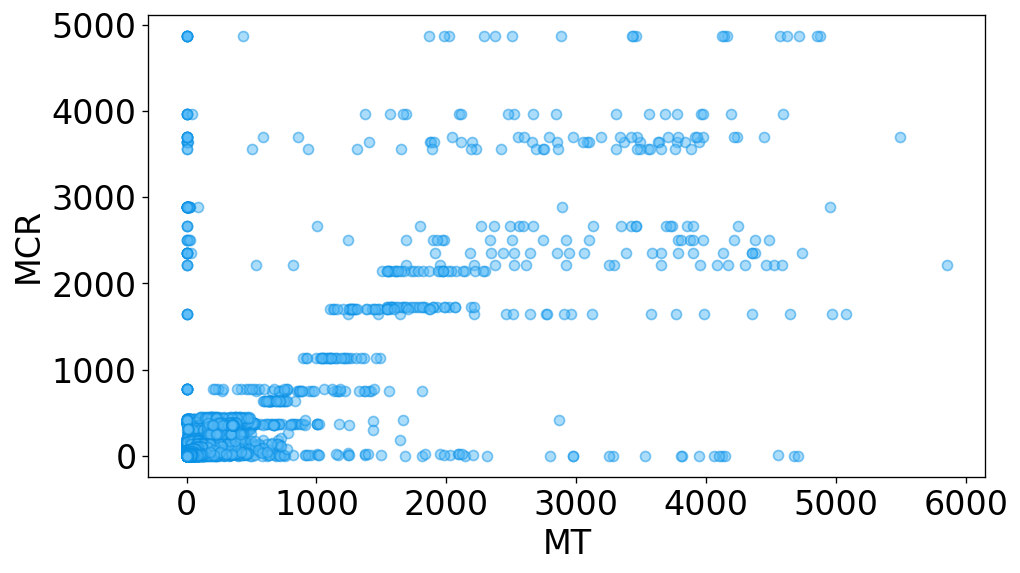

In [5]:
import matplotlib.pyplot as plt
plt.figure(figsize=(9, 5), dpi=120)
plt.scatter(x=X, y=Y, color="#59bbf7", marker="o",alpha=0.5, edgecolors="#0991e6")
plt.subplot().tick_params(labelsize=20)
plt.xlabel('MT', fontsize=20)
plt.ylabel('MCR', fontsize=20)
plt.show()

Reshape + Split

In [6]:
from sklearn.model_selection import train_test_split
X = X.reshape(-1, 1)

# split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)

# size
print("Train: ", X_train.shape)
print("Val: ", X_val.shape)
print("Test: ", X_test.shape)

Train:  (115196, 1)
Val:  (28800, 1)
Test:  (36000, 1)


Multilayer Perceptron Model

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim

In [8]:
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(1, 2),
            nn.Linear(2, 1)
        )

    def forward(self, x):
        return self.layers(x)

mlp = MLP()

Optimizer

In [9]:
optimizer = optim.Adam(mlp.parameters(), lr=0.003)

Loss Function

In [10]:
criterion = nn.L1Loss()

Converting data types to float32 tensors

In [11]:
X_train = torch.tensor(X_train.astype(np.float32))
Y_train = torch.tensor(Y_train.astype(np.float32))
X_val = torch.tensor(X_val.astype(np.float32))
Y_val = torch.tensor(Y_val.astype(np.float32))
X_test = torch.tensor(X_test.astype(np.float32))
Y_test = torch.tensor(Y_test.astype(np.float32))

Data Loader

In [12]:
from torch.utils.data import TensorDataset, DataLoader

train_dataset = TensorDataset(X_train, Y_train)

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test, Y_test)

test_loader = DataLoader(test_dataset, batch_size=64)

Training Loop

In [13]:
epochs = 3
losses = []

for epoch in range(epochs):
    mlp.train()
    epoch_loss = 0

    for input_data, target_data in train_loader:

        optimizer.zero_grad()
        # fp
        output = mlp(input_data)
        # loss
        loss = criterion(output, target_data.view(-1, 1))
        epoch_loss += loss.item()
        # bp
        loss.backward()
        # update
        optimizer.step()

    # avg loss
    avg_loss = epoch_loss / len(train_loader)
    losses.append(avg_loss)

    # print
    if epoch % 1 == 0:
        print("Epoch [{}/{}], Loss: {:.4f}".format(epoch, epochs, avg_loss))

Epoch [0/3], Loss: 9.9714
Epoch [1/3], Loss: 9.6114
Epoch [2/3], Loss: 9.6085


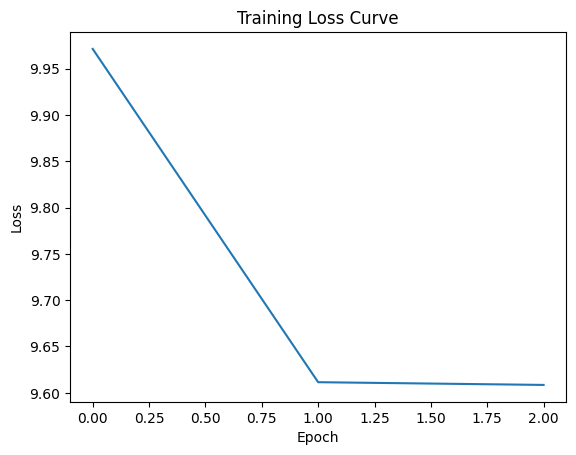

In [14]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training Loss Curve")
plt.show()

Test Loop

In [15]:
epochs = 3
losses = []

for epoch in range(epochs):
    mlp.train()
    epoch_loss = 0

    for input_data, target_data in test_loader:

        optimizer.zero_grad()
        # fp
        output = mlp(input_data)
        # loss
        loss = criterion(output, target_data.view(-1, 1))
        epoch_loss += loss.item()
        # bp
        loss.backward()
        # update
        optimizer.step()

    # avg loss
    avg_loss = epoch_loss / len(test_loader)
    losses.append(avg_loss)

    # print
    if epoch % 1 == 0:
        print("Epoch [{}/{}], Loss: {:.4f}".format(epoch, epochs, avg_loss))

Epoch [0/3], Loss: 9.3405
Epoch [1/3], Loss: 9.3395
Epoch [2/3], Loss: 9.3395


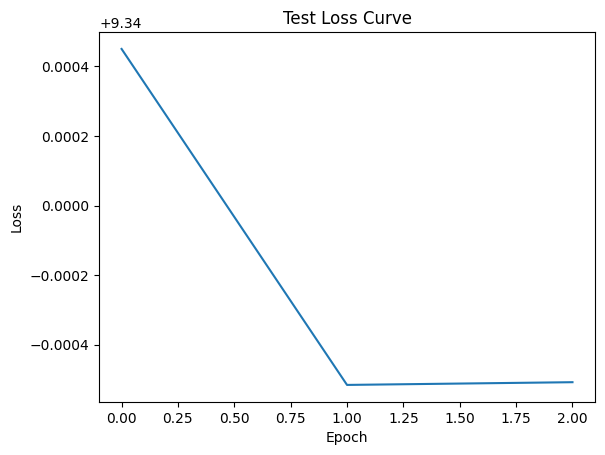

In [16]:
plt.plot(losses)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Test Loss Curve")
plt.show()

Predict

In [17]:
mlp.eval()
with torch.no_grad():
    Y_predict = mlp(X_test)
    Y_predict = Y_predict.numpy()
print(len(Y_predict))

36000


Errors

In [18]:
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
print("MAPE : ", mean_absolute_percentage_error(Y_test, Y_predict))
print("MAE : ", mean_absolute_error(Y_test, Y_predict))

MAPE :  16.702843
MAE :  9.325963


Scatter Plot

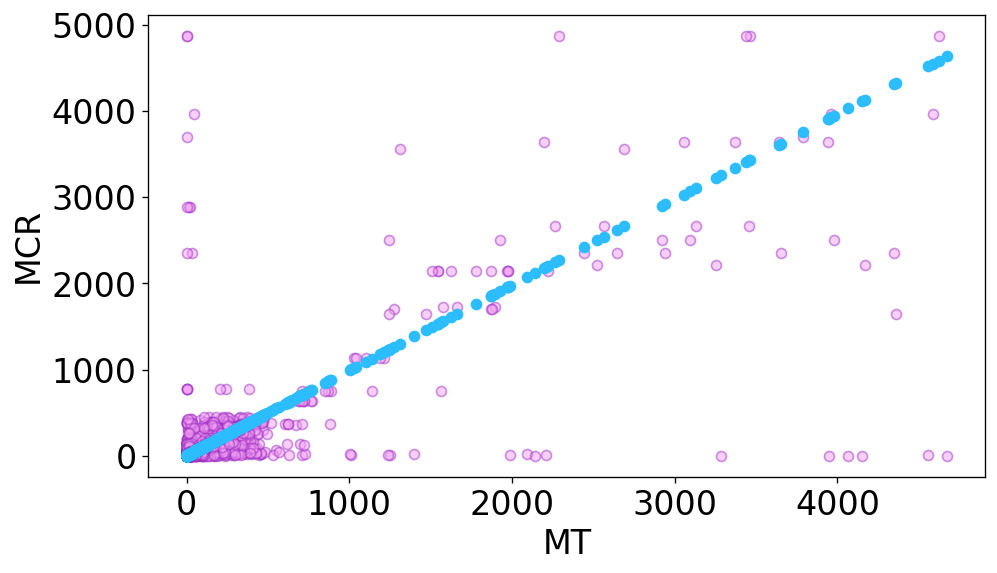

In [19]:
plt.figure(figsize=(9, 5), dpi=120)
plt.scatter(x=X_test, y=Y_test, color="#F3A0F2", marker="o",alpha=0.5, edgecolors="#9D2EC5")
plt.subplot().tick_params(labelsize=20)
plt.scatter(x=X_test, y=Y_predict, color="#2CBDFE", linewidth=1)
plt.ylabel('MCR', fontsize=20)
plt.xlabel('MT', fontsize=20)
plt.show()